In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ipl-dataset2008-2025/IPL.csv


In [3]:
import numpy as np
import pandas as pd

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout # Dropout added for regularization
from tensorflow.keras.callbacks import EarlyStopping # Optional: for early stopping

In [5]:
# --- 1. Data Loading ---
print("--- Loading Data ---")
try:
    # Try loading the dataset
    ipl_df = pd.read_csv('/kaggle/input/ipl-dataset2008-2025/IPL.csv')
    print("Dataset loaded successfully.")
    print(f"Initial shape: {ipl_df.shape}")
    
except FileNotFoundError:
    print("Error: IPL.csv not found. Please ensure the file path is correct.")
    # You might want to exit or use dummy data here if the file is essential
    exit() # Exit if the file cannot be loaded
 # Display first few rows and basic info
print("\n--- Initial Data ---")
print(ipl_df.head())
print("\n--- Initial Data Info ---")
ipl_df.info()

--- Loading Data ---


/tmp/ipykernel_36/3910030409.py:5: DtypeWarning: Columns (28,29,30,31,43,46,47,48,51) have mixed types. Specify dtype option on import or set low_memory=False.
  ipl_df = pd.read_csv('/kaggle/input/ipl-dataset2008-2025/IPL.csv')


Dataset loaded successfully.
Initial shape: (278205, 64)

--- Initial Data ---
   Unnamed: 0  match_id        date match_type             event_name  \
0      131970    335982  2008-04-18        T20  Indian Premier League   
1      131971    335982  2008-04-18        T20  Indian Premier League   
2      131972    335982  2008-04-18        T20  Indian Premier League   
3      131973    335982  2008-04-18        T20  Indian Premier League   
4      131974    335982  2008-04-18        T20  Indian Premier League   

   innings           batting_team                 bowling_team  over  ball  \
0        1  Kolkata Knight Riders  Royal Challengers Bangalore     0     1   
1        1  Kolkata Knight Riders  Royal Challengers Bangalore     0     2   
2        1  Kolkata Knight Riders  Royal Challengers Bangalore     0     3   
3        1  Kolkata Knight Riders  Royal Challengers Bangalore     0     3   
4        1  Kolkata Knight Riders  Royal Challengers Bangalore     0     4   

   ...  team_

In [6]:
# --- 2. Data Cleaning and Preparation ---
print("\n--- Cleaning and Preparing Data ---")
match_df = ipl_df.copy() # Work on a copy
 # List of current/consistent team names
teams = [
    'Sunrisers Hyderabad',
    'Mumbai Indians',
    'Royal Challengers Bengaluru',
    'Kolkata Knight Riders',
    'Punjab Kings',
    'Chennai Super Kings',
    'Rajasthan Royals',
    'Delhi Capitals',
    'Lucknow Super Giants',
    'Gujarat Titans'
]
 


--- Cleaning and Preparing Data ---


In [7]:
# Standardize team names (replace old names)
print("Standardizing team names...")
match_df['batting_team'] = match_df['batting_team'].str.replace('Delhi Daredevils', 'Delhi Capitals')
match_df['bowling_team'] = match_df['bowling_team'].str.replace('Delhi Daredevils', 'Delhi Capitals')
match_df['batting_team'] = match_df['batting_team'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')
match_df['bowling_team'] = match_df['bowling_team'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')
match_df['batting_team'] = match_df['batting_team'].str.replace('Kings XI Punjab', 'Punjab Kings')
match_df['bowling_team'] = match_df['bowling_team'].str.replace('Kings XI Punjab', 'Punjab Kings')
match_df['batting_team'] = match_df['batting_team'].str.replace('Rising Pune Supergiant', 'Rising Pune Supergiants') # Consistent naming if needed
match_df['bowling_team'] = match_df['bowling_team'].str.replace('Rising Pune Supergiant', 'Rising Pune Supergiants')
# Replace RCB's old name
match_df['batting_team'] = match_df['batting_team'].str.replace('Royal Challengers Bangalore','Royal Challengers Bengaluru')
match_df['bowling_team'] = match_df['bowling_team'].str.replace('Royal Challengers Bangalore','Royal Challengers Bengaluru')

Standardizing team names...


In [8]:
# Filter for matches involving only the specified teams
print(f"Shape before filtering teams: {match_df.shape}")
match_df = match_df[match_df['batting_team'].isin(teams)]
match_df = match_df[match_df['bowling_team'].isin(teams)]
print(f"Shape after filtering teams: {match_df.shape}")
 # Filter for second innings only (predicting the chase)
print(f"Shape before filtering for 2nd innings: {match_df.shape}")
match_df = match_df[match_df['innings'] == 2].copy() # Use .copy() to avoid SettingWithCopyWarning
print(f"Shape after filtering for 2nd innings: {match_df.shape}")
 

Shape before filtering teams: (278205, 64)
Shape after filtering teams: (251186, 64)
Shape before filtering for 2nd innings: (251186, 64)
Shape after filtering for 2nd innings: (120967, 64)


In [9]:
# --- 3. Feature Engineering ---
print("\n--- Engineering Features ---")
# Calculate runs left
match_df['runs_left'] = match_df['runs_target'] - match_df['team_runs']
# Calculate balls left
match_df['balls_left'] = 120 - match_df['team_balls']
 # Calculate wickets left
match_df['wickets_left'] = 10 - match_df['team_wicket']
 # Calculate current run rate (CRR) - handle division by zero if team_balls is 0
match_df['crr'] = np.where(match_df['team_balls'] == 0, 0, (match_df['team_runs'] * 6) / match_df['team_balls'])
 # Calculate required run rate (RRR) - handle division by zero if balls_left is 0
match_df['rrr'] = np.where(match_df['balls_left'] == 0, np.inf, (match_df['runs_left'] * 6) / match_df['balls_left'])
# Replace infinite RRR (when runs_left > 0 and balls_left == 0) with a large number or handle as needed
match_df['rrr'] = match_df['rrr'].replace([np.inf, -np.inf], 999) # Or another suitable large value
 # Define the target variable: 1 if batting team won, 0 otherwise
def result(row):
    return 1 if row['batting_team'] == row['match_won_by'] else 0
    
match_df['result'] = match_df.apply(result, axis=1)
 # Select final features for the model
print("Selecting final features...")
final_df = match_df[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 'wickets_left', 'runs_target', 'crr', 'rrr', 'result']].copy() 


--- Engineering Features ---
Selecting final features...


In [10]:
# --- 4. Final Data Cleaning and Preparation for Modeling ---
print("\n--- Final Data Cleaning ---")
 # Shuffle the DataFrame
final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True) # Use frac=1 for shuffling all rows
 # Drop rows with missing values (especially important for 'city' or if other NaNs exist)
print(f"Shape before dropping NA: {final_df.shape}")
final_df.dropna(inplace=True)
print(f"Shape after dropping NA: {final_df.shape}")
 # Remove edge cases where balls_left is 0 (match ended) or 120 (chase hasn't started)
# Note: RRR calculation already handled balls_left=0, but removing the row might still be desired
print(f"Shape before removing edge cases (balls_left): {final_df.shape}")
final_df = final_df[final_df['balls_left'] != 0]
final_df = final_df[final_df['balls_left'] != 120] # Ensure chase has started
print(f"Shape after removing edge cases: {final_df.shape}")
print("\n--- Final DataFrame Info ---")
final_df.info()
print(final_df.head())


--- Final Data Cleaning ---
Shape before dropping NA: (120967, 10)
Shape after dropping NA: (120967, 10)
Shape before removing edge cases (balls_left): (120967, 10)
Shape after removing edge cases: (120495, 10)

--- Final DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 120495 entries, 0 to 120966
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   batting_team  120495 non-null  object 
 1   bowling_team  120495 non-null  object 
 2   city          120495 non-null  object 
 3   runs_left     120495 non-null  float64
 4   balls_left    120495 non-null  int64  
 5   wickets_left  120495 non-null  int64  
 6   runs_target   120495 non-null  float64
 7   crr           120495 non-null  float64
 8   rrr           120495 non-null  float64
 9   result        120495 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 10.1+ MB
            batting_team           bowling_team        city  

In [11]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Example: One-hot encode categorical variables using sklearn
trf = ColumnTransformer([
    ('trf', OneHotEncoder(sparse=False, drop='first'), ['batting_team', 'bowling_team', 'city'])
], remainder='passthrough')

# Apply transformation to features
X = final_df.iloc[:, :-1]
y = final_df.iloc[:, -1].values.reshape(-1, 1)  # Convert to column vector
X_transformed = trf.fit_transform(X)  # One-hot encoding

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=1)

# Feature Scaling (Normalization)
epsilon = 1e-8  # To avoid division by zero
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
X_train_std[X_train_std == 0] = epsilon  # Replace zero std values

X_train = (X_train - X_train.mean(axis=0)) / X_train_std
X_test = (X_test - X_test.mean(axis=0)) / X_train_std  # Use training std to scale test data

# Initialize parameters
n_features = X_train.shape[1]
weights = np.zeros((n_features, 1))  # Weight vector
bias = 0
learning_rate = 0.01
epochs = 1000

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Cost function (Log loss)
def compute_cost(X, y, weights, bias):
    m = len(y)
    z = np.dot(X, weights) + bias
    predictions = sigmoid(z)
    cost = - (1 / m) * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    return cost

# Gradient Descent
def gradient_descent(X, y, weights, bias, learning_rate, epochs):
    m = len(y)
    for epoch in range(epochs):
        z = np.dot(X, weights) + bias
        predictions = sigmoid(z)

        # Compute gradients
        dw = (1 / m) * np.dot(X.T, (predictions - y))
        db = (1 / m) * np.sum(predictions - y)

        # Update weights and bias
        weights -= learning_rate * dw
        bias -= learning_rate * db

        # Print cost every 100 epochs
        if epoch % 100 == 0:
            cost = compute_cost(X, y, weights, bias)
            print(f"Epoch {epoch}, Cost: {cost:.4f}")

    return weights, bias




/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Assuming sigmoid, gradient_descent, X_train, y_train, X_test, y_test are already defined

# Train the model
weights, bias = gradient_descent(X_train, y_train, weights, bias, learning_rate, epochs)

# Prediction function
def predict(X, weights, bias, threshold=0.5):
    return (sigmoid(np.dot(X, weights) + bias) >= threshold).astype(int)

# Predictions on test data
y_pred = predict(X_test, weights, bias)

# Accuracy calculation
accuracy = accuracy_score(y_test, y_pred) * 100
print("--- Evaluating the Random Forest Model ---")  # You can change "Random Forest" to your model name
print(f"Test Accuracy: {accuracy:.2f}%\n")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=2))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Epoch 0, Cost: 0.6919
Epoch 100, Cost: 0.6008
Epoch 200, Cost: 0.5502
Epoch 300, Cost: 0.5192
Epoch 400, Cost: 0.4985
Epoch 500, Cost: 0.4839
Epoch 600, Cost: 0.4731
Epoch 700, Cost: 0.4648
Epoch 800, Cost: 0.4583
Epoch 900, Cost: 0.4530
--- Evaluating the Random Forest Model ---
Test Accuracy: 80.06%

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84     15042
           1       0.74      0.72      0.73      9057

    accuracy                           0.80     24099
   macro avg       0.79      0.78      0.79     24099
weighted avg       0.80      0.80      0.80     24099

Confusion Matrix:
[[12776  2266]
 [ 2540  6517]]


In [13]:
import pandas as pd

conf_matrix = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(conf_matrix)

print("Confusion Matrix:")
print(conf_df.to_string(index=False, header=False))


Confusion Matrix:
12776 2266
 2540 6517


In [14]:

# Train the model
weights, bias = gradient_descent(X_train, y_train, weights, bias, learning_rate, epochs)

# Prediction function
def predict(X, weights, bias, threshold=0.5):
    return (sigmoid(np.dot(X, weights) + bias) >= threshold).astype(int)

# Predictions on test data
y_pred = predict(X_test, weights, bias)

# Accuracy calculation
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# Get probability for a sample
sample_index = 500
probability = sigmoid(np.dot(X_test[sample_index], weights) + bias)
print(f"Probability of class 1 for sample {sample_index}: {probability.item():.4f}")



Epoch 0, Cost: 0.4486
Epoch 100, Cost: 0.4450
Epoch 200, Cost: 0.4419
Epoch 300, Cost: 0.4392
Epoch 400, Cost: 0.4369
Epoch 500, Cost: 0.4348
Epoch 600, Cost: 0.4330
Epoch 700, Cost: 0.4314
Epoch 800, Cost: 0.4300
Epoch 900, Cost: 0.4287
Test Accuracy: 80.76%
Probability of class 1 for sample 500: 0.1703


In [15]:

# Function to predict win probability for custom input
def predict_custom_input(batting_team, bowling_team, city, runs_left, balls_left, wickets_left, runs_target, crr, rrr):
    """
    Predict win probability for custom input values
    
    Parameters:
    batting_team - Name of batting team
    bowling_team - Name of bowling team
    city - Match venue/city
    runs_left - Runs needed to win
    balls_left - Balls remaining
    wickets_left - Wickets in hand (wickets remaining)
    runs_target - Target score
    crr - Current run rate
    rrr - Required run rate
    
    Returns:
    win_probability - Probability of the batting team winning
    result - Win or Loss prediction
    """
    # Create a DataFrame with one row containing the input features
    # Using the exact same column names as in the original dataframe
    input_df = pd.DataFrame({
        'batting_team': [batting_team],
        'bowling_team': [bowling_team],
        'city': [city],
        'runs_left': [runs_left],
        'balls_left': [balls_left],
        'wickets_left': [wickets_left],
        'runs_target': [runs_target],
        'crr': [crr],
        'rrr': [rrr]
    })
    
    # Apply the same transformation as for the training data
    input_transformed = trf.transform(input_df)
    
    # Apply the same scaling as for the training data
    input_scaled = (input_transformed - X_train_mean) / X_train_std
    
    # Get the win probability
    win_probability = sigmoid(np.dot(input_scaled, weights) + bias).item()
    
    # Determine the result
    result = "Win" if win_probability >= 0.5 else "Loss"
    
    return win_probability, result

# CUSTOM INPUT SECTION - MODIFY VALUES HERE
# --------------------------------------------
# Example values (replace with your own):
batting_team = "Royal Challengers Bengaluru"
bowling_team = "Rajasthan Royals"
city = "Jaipur"
runs_left = 80.0
balls_left = 58
wickets_left = 7
runs_target = 165.0
crr = 8.225806
rrr = 8.275862
result = 0
# --------------------------------------------
#Royal Challengers Bengaluru	Kolkata Knight Riders	Kolkata	106.0	34	6	191.0	5.930233 18.705882
#Sunrisers Hyderabad	Royal Challengers Bengaluru	Hyderabad	112.0	104	9	131.0	7.125	6.461538
#
# Get prediction for custom input
win_probability, result = predict_custom_input(
    batting_team, bowling_team, city, runs_left, balls_left, 
    wickets_left, runs_target, crr, rrr
)

# Print the results
print("\n--- Custom Input Prediction ---")
print(f"Batting Team: {batting_team}")
print(f"Bowling Team: {bowling_team}")
print(f"City: {city}")
print(f"Runs Left: {runs_left}")
print(f"Balls Left: {balls_left}")
print(f"Wickets in Hand: {wickets_left}")
print(f"Target Score: {runs_target}")
print(f"Current Run Rate: {crr}")
print(f"Required Run Rate: {rrr}")
print(f"Win Probability: {win_probability:.4f} ({win_probability*100:.2f}%)")
print(f"Predicted Result: {result}")


--- Custom Input Prediction ---
Batting Team: Royal Challengers Bengaluru
Bowling Team: Rajasthan Royals
City: Jaipur
Runs Left: 80.0
Balls Left: 58
Wickets in Hand: 7
Target Score: 165.0
Current Run Rate: 8.225806
Required Run Rate: 8.275862
Win Probability: 0.1702 (17.02%)
Predicted Result: Loss


**Match Progression ..**

In [16]:
def match_progression(x_df, match_id, weights, bias):
    match = x_df[x_df['match_id'] == match_id]
    match = match[(match['ball'] == 6)]  # Consider end of over data

    # Select relevant features
    temp_df = match[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 'wickets_left', 'runs_target', 'crr', 'rrr']].dropna()
    temp_df = temp_df[temp_df['balls_left'] != 0]  # Remove instances where no balls are left

    # Apply same transformations as training
    temp_df_transformed = trf.transform(temp_df)  # One-hot encoding
    temp_df_transformed = (temp_df_transformed - X_train.mean(axis=0)) / X_train_std  # Normalize

    # Compute probabilities using our logistic regression model
    result = sigmoid(np.dot(temp_df_transformed, weights) + bias)

    temp_df['lose'] = np.round((1 - result) * 100, 1)  # Probability of losing
    temp_df['win'] = np.round(result * 100, 1)         # Probability of winning
    temp_df['end_of_over'] = range(1, temp_df.shape[0] + 1)

    # Extract match target
    target = temp_df['runs_target'].values[0]

    # Runs calculation
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0, target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)

    # Wickets calculation
    wickets = list(temp_df['wickets_left'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0, 10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]

    print("Target:", target)
    temp_df = temp_df[['end_of_over', 'runs_after_over', 'wickets_in_over', 'lose', 'win']]
    return temp_df, target



In [17]:
# **Test the function**
temp_df, target = match_progression(match_df, 1254108, weights, bias)
temp_df


Target: 166.0


,end_of_over,runs_after_over,wickets_in_over,lose,win
202920,1,5.0,0,59.9,40.1
202926,2,5.0,0,58.8,41.2
202933,3,17.0,0,44.1,55.9
202939,4,9.0,0,41.8,58.2
202945,5,15.0,0,34.8,65.2
202952,6,5.0,0,35.7,64.3
202958,7,2.0,1,45.8,54.2
202964,8,5.0,0,45.2,54.8
202965,9,6.0,0,41.9,58.1
202971,10,6.0,0,41.2,58.8


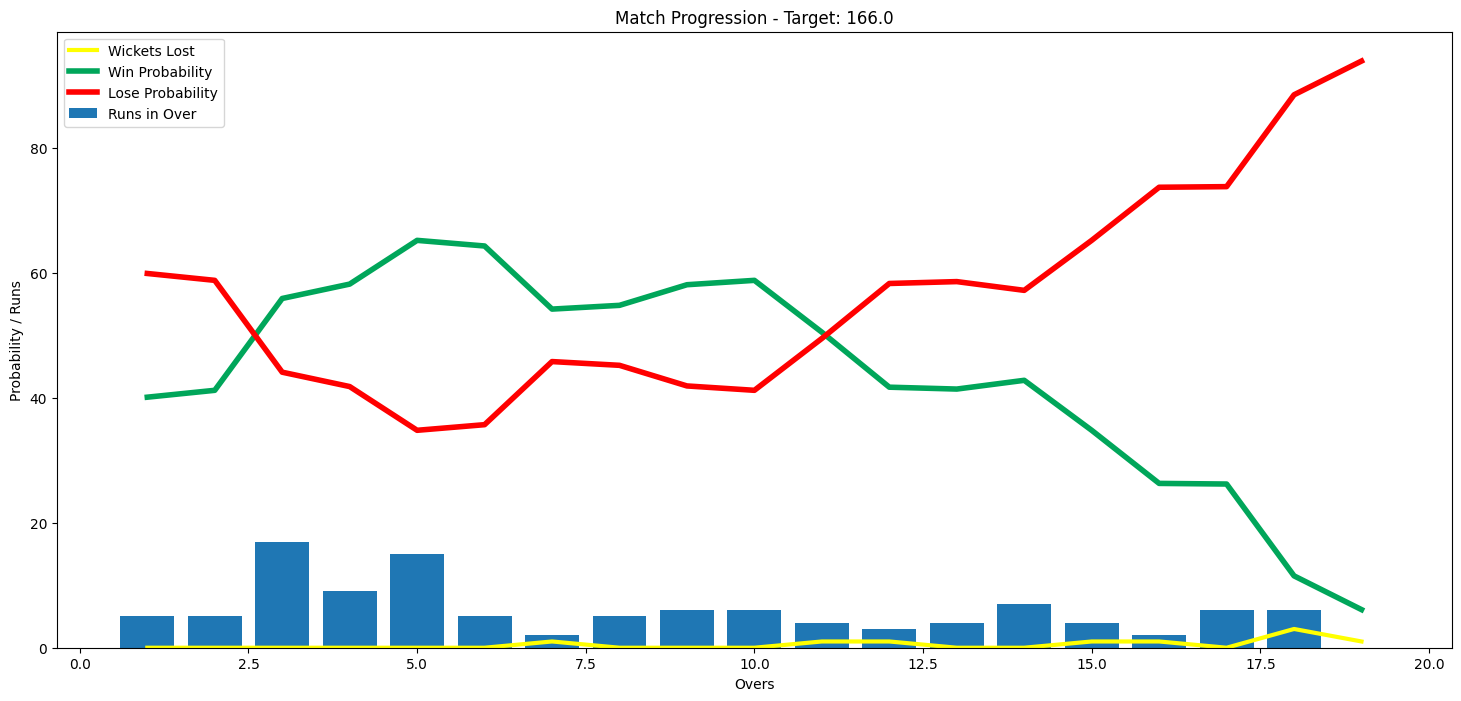

In [18]:
# **Plot the match progression**
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
plt.plot(temp_df['end_of_over'], temp_df['wickets_in_over'], color='yellow', linewidth=3, label="Wickets Lost")
plt.plot(temp_df['end_of_over'], temp_df['win'], color='#00a65a', linewidth=4, label="Win Probability")
plt.plot(temp_df['end_of_over'], temp_df['lose'], color='red', linewidth=4, label="Lose Probability")
plt.bar(temp_df['end_of_over'], temp_df['runs_after_over'], label="Runs in Over")

plt.title(f'Match Progression - Target: {target}')
plt.xlabel("Overs")
plt.ylabel("Probability / Runs")
plt.legend()
plt.show()


**ANN Model**

In [19]:
# --- 3. Feature Engineering ---
print("\n--- Engineering Features ---")

# Calculate runs left
match_df['runs_left'] = match_df['runs_target'] - match_df['team_runs']

# Calculate balls left
match_df['balls_left'] = 120 - match_df['team_balls']

# Calculate wickets left
match_df['wickets_left'] = 10 - match_df['team_wicket']

# Calculate current run rate (CRR) - handle division by zero if team_balls is 0
match_df['crr'] = np.where(match_df['team_balls'] == 0, 0, (match_df['team_runs'] * 6) / match_df['team_balls'])

# Calculate required run rate (RRR) - handle division by zero if balls_left is 0
match_df['rrr'] = np.where(match_df['balls_left'] == 0, np.inf, (match_df['runs_left'] * 6) / match_df['balls_left'])
# Replace infinite RRR (when runs_left > 0 and balls_left == 0) with a large number or handle as needed
match_df['rrr'] = match_df['rrr'].replace([np.inf, -np.inf], 999) # Or another suitable large value


# Define the target variable: 1 if batting team won, 0 otherwise
def result(row):
    return 1 if row['batting_team'] == row['match_won_by'] else 0

match_df['result'] = match_df.apply(result, axis=1)

# Select final features for the model
print("Selecting final features...")
final_df = match_df[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 'wickets_left', 'runs_target', 'crr', 'rrr', 'result']].copy()




--- Engineering Features ---
Selecting final features...


In [20]:
# --- 4. Final Data Cleaning and Preparation for Modeling ---
print("\n--- Final Data Cleaning ---")

# Shuffle the DataFrame
final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True) # Use frac=1 for shuffling all rows

# Drop rows with missing values (especially important for 'city' or if other NaNs exist)
print(f"Shape before dropping NA: {final_df.shape}")
final_df.dropna(inplace=True)
print(f"Shape after dropping NA: {final_df.shape}")

# Remove edge cases where balls_left is 0 (match ended) or 120 (chase hasn't started)
# Note: RRR calculation already handled balls_left=0, but removing the row might still be desired
print(f"Shape before removing edge cases (balls_left): {final_df.shape}")
final_df = final_df[final_df['balls_left'] != 0]
final_df = final_df[final_df['balls_left'] != 120] # Ensure chase has started
print(f"Shape after removing edge cases: {final_df.shape}")

print("\n--- Final DataFrame Info ---")
final_df.info()
print(final_df.head())




--- Final Data Cleaning ---
Shape before dropping NA: (120967, 10)
Shape after dropping NA: (120967, 10)
Shape before removing edge cases (balls_left): (120967, 10)
Shape after removing edge cases: (120495, 10)

--- Final DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 120495 entries, 0 to 120966
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   batting_team  120495 non-null  object 
 1   bowling_team  120495 non-null  object 
 2   city          120495 non-null  object 
 3   runs_left     120495 non-null  float64
 4   balls_left    120495 non-null  int64  
 5   wickets_left  120495 non-null  int64  
 6   runs_target   120495 non-null  float64
 7   crr           120495 non-null  float64
 8   rrr           120495 non-null  float64
 9   result        120495 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 10.1+ MB
            batting_team           bowling_team        city  

In [21]:
# --- 5. Preprocessing for ANN ---
print("\n--- Preprocessing Data for ANN ---")

# Define features (X) and target (y)
X = final_df.drop('result', axis=1)
y = final_df['result'].values # Keep y as a 1D array for Keras binary classification

# Define categorical and numerical features (ensure consistency with final_df columns)
categorical_features = ['batting_team', 'bowling_team', 'city']
numerical_features = ['runs_left', 'balls_left', 'wickets_left', 'runs_target', 'crr', 'rrr']

# Create the ColumnTransformer for OneHotEncoding categorical features
# handle_unknown='ignore' helps if match_progression encounters a city not in training data
# sparse_output=False is needed for StandardScaler and Keras Dense layers
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep numerical columns
)

# Apply ColumnTransformer (fit on the entire X before splitting to learn all categories)
print("Applying OneHotEncoding...")
X_processed = preprocessor.fit_transform(X)
print(f"Shape of X after OneHotEncoding: {X_processed.shape}")

# Split data into training and testing sets
print("Splitting data into Training and Testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y) # Stratify helps maintain class balance
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


# Feature Scaling (Standardization - important for ANNs)
print("Applying Feature Scaling (StandardScaler)...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Fit scaler only on training data
X_test_scaled = scaler.transform(X_test)       # Transform test data using training scaler




--- Preprocessing Data for ANN ---
Applying OneHotEncoding...
Shape of X after OneHotEncoding: (120495, 58)
Splitting data into Training and Testing sets...
X_train shape: (96396, 58), y_train shape: (96396,)
X_test shape: (24099, 58), y_test shape: (24099,)
Applying Feature Scaling (StandardScaler)...


In [22]:
# --- 6. Build the ANN Model ---
print("\n--- Building the ANN Model ---")
n_features = X_train_scaled.shape[1] # Number of input features after preprocessing

model = Sequential(name="IPL_Win_Probability_ANN")
model.add(Input(shape=(n_features,), name="Input_Layer"))
model.add(Dense(units=128, activation='relu', name="Hidden_Layer_1")) # Increased units
model.add(Dropout(0.3)) # Dropout for regularization to prevent overfitting
model.add(Dense(units=64, activation='relu', name="Hidden_Layer_2"))
model.add(Dropout(0.3 )) # Dropout layer
model.add(Dense(units=1, activation='sigmoid', name="Output_Layer")) # Sigmoid for binary probability output

# Compile the model
# Adam optimizer is generally a good starting point. Binary crossentropy for binary classification.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()




--- Building the ANN Model ---


2025-08-20 05:19:23.557048: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "IPL_Win_Probability_ANN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)          │ (None, 128)            │         7,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,873 (62.00 KB)

 Trainable params: 15,873 (62.00 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# --- 7. Train the ANN Model ---
print("\n--- Training the ANN Model ---")
epochs = 10 # Number of training iterations (can be adjusted)
batch_size = 64 # Number of samples per gradient update

# Optional: Early stopping to prevent overfitting
# Monitors validation loss and stops if it doesn't improve for 'patience' epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_scaled, y_test), # Monitor performance on test set
    callbacks=[early_stopping], # Use early stopping callback
    verbose=1 # Show progress (can set to 2 for less output or 0 for silent)
)




--- Training the ANN Model ---
Epoch 1/10
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8025 - loss: 0.4098 - val_accuracy: 0.9175 - val_loss: 0.2010
Epoch 2/10
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9089 - loss: 0.2151 - val_accuracy: 0.9422 - val_loss: 0.1410
Epoch 3/10
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9264 - loss: 0.1705 - val_accuracy: 0.9538 - val_loss: 0.1065
Epoch 4/10
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9381 - loss: 0.1423 - val_accuracy: 0.9618 - val_loss: 0.0895
Epoch 5/10
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9475 - loss: 0.1207 - val_accuracy: 0.9664 - val_loss: 0.0764
Epoch 6/10
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9546 - loss: 0.1062 - val_accuracy: 0.9724 - val_loss: 0.0662
Epoch 7/10
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9587 - loss: 0.0969 - val_accuracy: 0.9757 - val_loss: 0.0618
Epoch 8/10
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - ac

In [24]:
# --- 8. Evaluate the Model ---
print("\n--- Evaluating the ANN Model ---")

# Evaluate on the test set
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Make predictions on the test set
y_pred_prob = model.predict(X_test_scaled)
y_pred_classes = (y_pred_prob > 0.5).astype(int).flatten() # Convert probabilities to 0 or 1

# Display classification report and confusion matrix for more detailed evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))



--- Evaluating the ANN Model ---
Test Loss: 0.0473
Test Accuracy: 98.17%
754/754 ━━━━━━━━━━━━━━━━━━━━ 1s 977us/step

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     14960
           1       0.98      0.97      0.98      9139

    accuracy                           0.98     24099
   macro avg       0.98      0.98      0.98     24099
weighted avg       0.98      0.98      0.98     24099

Confusion Matrix:
[[14776   184]
 [  256  8883]]


In [25]:
# --- 9. Get Probability for a Single Sample ---
print("\n--- Predicting Probability for a Sample ---")
sample_index = 500 # Index from the original test set (before scaling)
if sample_index < len(X_test_scaled):
    sample_features_scaled = X_test_scaled[sample_index].reshape(1, -1) # Reshape for Keras

    probability = model.predict(sample_features_scaled)[0][0]
    actual_label = y_test[sample_index]
    predicted_label = y_pred_classes[sample_index]

    print(f"Sample Index (in test set): {sample_index}")
    print(f"Predicted Probability of Win (Class 1): {probability:.4f}")
    print(f"Predicted Label (Threshold 0.5): {predicted_label}")
    print(f"Actual Label: {actual_label}")
else:
    print(f"Sample index {sample_index} is out of bounds for the test set (size {len(X_test_scaled)}).")




--- Predicting Probability for a Sample ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Sample Index (in test set): 500
Predicted Probability of Win (Class 1): 0.9790
Predicted Label (Threshold 0.5): 1
Actual Label: 1


In [26]:
# --- 10. Match Progression Function (Adapted for ANN) ---
print("\n--- Defining Match Progression Function for ANN ---")

def match_progression_ann(match_data_full, match_id, trained_model, column_transformer, scaler_instance):
    """
    Calculates and returns win/loss probability progression for a given match using a trained ANN.

    Args:
        match_data_full (pd.DataFrame): The DataFrame containing ball-by-ball data for ALL matches (like the initial match_df).
        match_id (int): The ID of the match to analyze.
        trained_model (tf.keras.Model): The trained Keras ANN model.
        column_transformer (ColumnTransformer): The fitted ColumnTransformer (used for OneHotEncoding).
        scaler_instance (StandardScaler): The fitted StandardScaler instance.

    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: DataFrame with progression details (over, runs, wickets, win/loss %).
            - int: The target score for the chasing team.
        Returns (None, None) if the match_id is not found or has issues.
    """
    print(f"\n--- Analyzing Match Progression for Match ID: {match_id} ---")
    match = match_data_full[match_data_full['match_id'] == match_id].copy()

    if match.empty:
        print(f"Error: Match ID {match_id} not found in the dataset.")
        return None, None

    # Filter for 2nd innings (should already be done if match_data_full is pre-filtered, but good safety check)
    match = match[match['innings'] == 2]
    if match.empty:
        print(f"Error: No 2nd innings data found for Match ID {match_id}.")
        return None, None

    # Aggregate data at the end of each over (using 'ball' == 6, assuming 6 balls/over)
    # Or aggregate based on over number if 'ball' column isn't reliable
    # For simplicity, let's use a common approach: Group by over and take the last ball's state
    # Ensure 'over' and 'ball' columns exist and are suitable
    if 'over' not in match.columns or 'ball' not in match.columns:
         print("Error: 'over' or 'ball' column missing for end-of-over aggregation.")
         # Fallback: Maybe use team_balls? Requires careful handling.
         # Using team_balls to approximate end of over:
         match['over_approx'] = (match['team_balls'] // 6) + 1
         match = match.loc[match.groupby('over_approx')['team_balls'].idxmax()] # Get row with max balls in that over
         match['end_of_over'] = match['over_approx']
         # match = match[(match['ball'] == 6)] # Original approach if 'ball' column reliable
    else:
        match = match.sort_values(by=['over', 'ball'])
        match = match.loc[match.groupby('over')['ball'].idxmax()] # Get last ball state of each over
        match['end_of_over'] = match['over']


    # Recalculate features needed based on the state at the end of the over
    match['runs_left'] = match['runs_target'] - match['team_runs']
    match['balls_left'] = 120 - match['team_balls']
    match['wickets_left'] = 10 - match['team_wicket']
    match['crr'] = np.where(match['team_balls'] == 0, 0, (match['team_runs'] * 6) / match['team_balls'])
    match['rrr'] = np.where(match['balls_left'] == 0, 999, (match['runs_left'] * 6) / match['balls_left']) # Use 999 for inf RRR

    # Select features required by the model (must match columns used for training X)
    features_to_select = ['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 'wickets_left', 'runs_target', 'crr', 'rrr']
    temp_df = match[features_to_select].copy().dropna()

    # Remove states where the chase is over or hasn't started (if any remain after aggregation)
    temp_df = temp_df[temp_df['balls_left'] > 0]
    temp_df = temp_df[temp_df['balls_left'] < 120]

    if temp_df.empty:
        print(f"No valid states found for prediction after filtering for Match ID {match_id}.")
        # Attempt to get target anyway if needed, or return None
        target = match['runs_target'].iloc[0] if not match.empty else "Unknown"
        print(f"Target: {target}")
        return pd.DataFrame(), target # Return empty dataframe and target

    # --- Apply the SAME preprocessing as during training ---
    # 1. OneHotEncode using the fitted ColumnTransformer
    try:
        temp_df_processed = column_transformer.transform(temp_df)
    except Exception as e:
        print(f"Error during ColumnTransformer transformation: {e}")
        # Print columns expected vs columns present if error persists
        # print("Expected columns by transformer:", column_transformer.feature_names_in_)
        # print("Columns in temp_df:", temp_df.columns)
        return None, None


    # 2. Scale using the fitted StandardScaler
    try:
        temp_df_scaled = scaler_instance.transform(temp_df_processed)
    except Exception as e:
        print(f"Error during StandardScaler transformation: {e}")
        return None, None

    # --- Predict probabilities using the trained ANN model ---
    probabilities = trained_model.predict(temp_df_scaled)

    # Add results back to the (non-processed) temp_df for context
    temp_df['win_prob'] = probabilities.flatten() # Probability of winning (class 1)
    temp_df['lose_prob'] = 1.0 - temp_df['win_prob'] # Probability of losing

    temp_df['win'] = np.round(temp_df['win_prob'] * 100, 1)
    temp_df['lose'] = np.round(temp_df['lose_prob'] * 100, 1)

    # Add end_of_over if not already present (depends on aggregation method)
    if 'end_of_over' not in temp_df.columns:
         temp_df['end_of_over'] = range(1, temp_df.shape[0] + 1) # Simple range if needed

    # Calculate runs and wickets per over for plotting
    target = temp_df['runs_target'].iloc[0]
    print(f"Target for Match ID {match_id}: {target}")

    # Runs per over calculation (compare runs_left between consecutive overs)
    runs_left_values = list(temp_df['runs_left'].values)
    # Add target as the initial 'runs_left' before the first over
    runs_left_values.insert(0, target)
    # Runs scored = runs_left_previous_over - runs_left_current_over
    temp_df['runs_after_over'] = np.array(runs_left_values[:-1]) - np.array(temp_df['runs_left'].values)


    # Wickets per over calculation (compare wickets_left between consecutive overs)
    wickets_left_values = list(temp_df['wickets_left'].values)
    # Start with 10 wickets before the first over
    wickets_left_values.insert(0, 10)
    # Wickets lost = wickets_left_previous_over - wickets_left_current_over
    temp_df['wickets_in_over'] = np.array(wickets_left_values[:-1]) - np.array(temp_df['wickets_left'].values)


    # Select final columns for the output DataFrame
    output_df = temp_df[['end_of_over', 'runs_after_over', 'wickets_in_over', 'lose', 'win']].copy()

    # Add a row for the start of the match (Over 0)
    start_row = pd.DataFrame({
        'end_of_over': [0],
        'runs_after_over': [0],
        'wickets_in_over': [0],
        # Estimate initial probability if possible, or set defaults
        # Requires predicting on the state before the first ball
        'lose': [50.0], # Placeholder: Initial probability is often assumed 50/50 or based on pre-match factors
        'win': [50.0]   # Placeholder
    })
    output_df = pd.concat([start_row, output_df], ignore_index=True)


    return output_df, target




--- Defining Match Progression Function for ANN ---



--- Testing Match Progression Function ---

--- Analyzing Match Progression for Match ID: 1136564 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Target for Match ID 1136564: 126.0

--- Plotting Match Progression ---


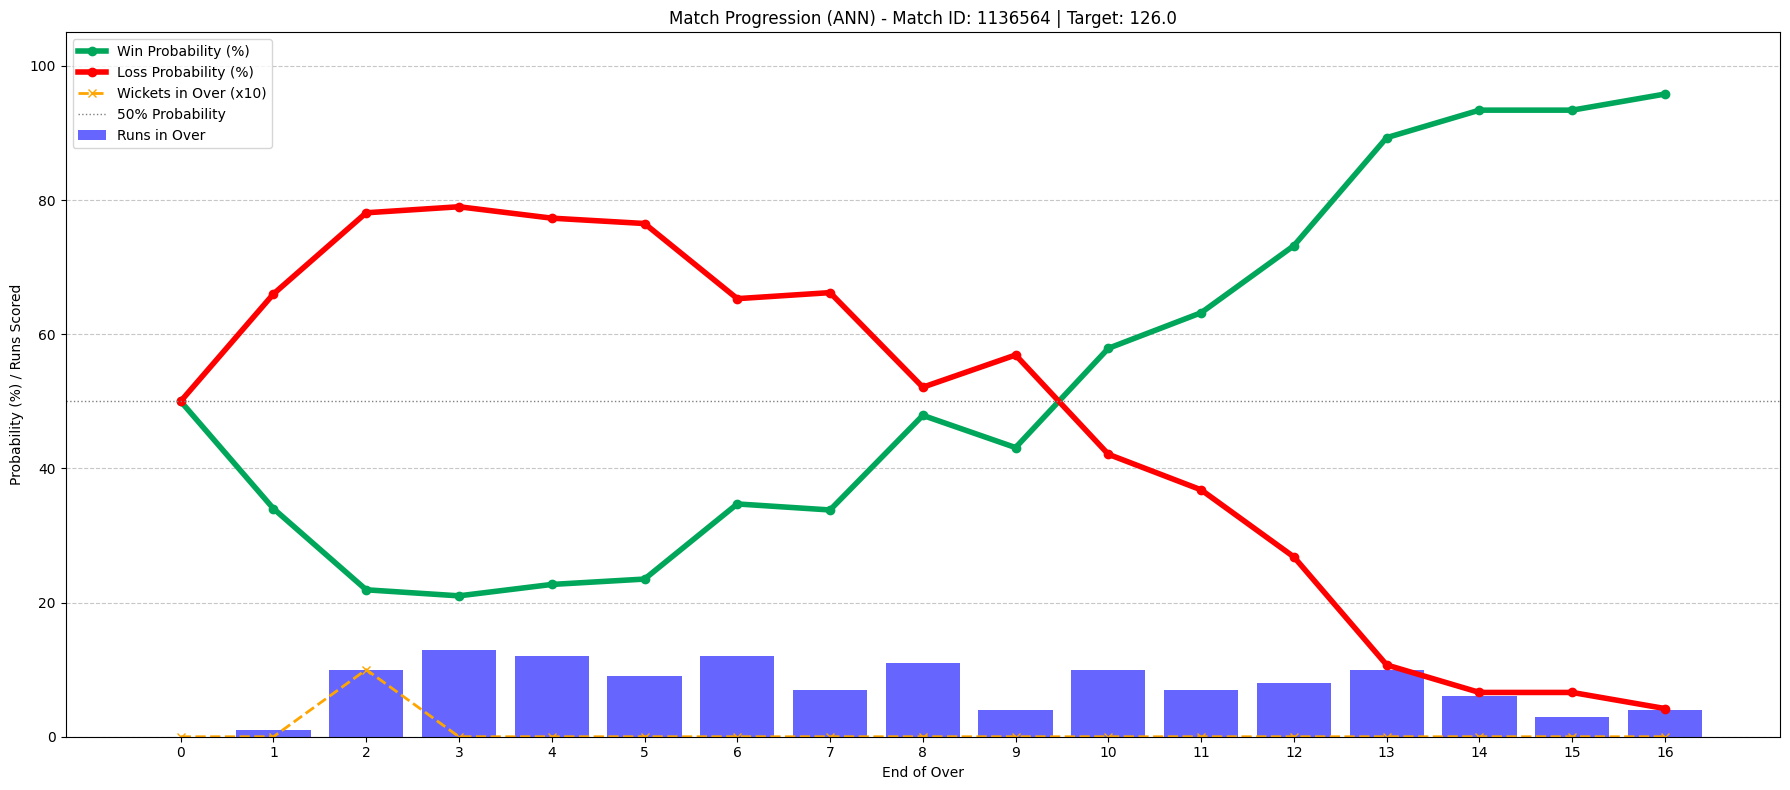


--- Script Finished ---


In [27]:

# --- 11. Test the Match Progression Function and Plot ---
print("\n--- Testing Match Progression Function ---")

# Use the correct DataFrame containing all match data before final selections
# This should be the 'match_df' after cleaning team names and filtering innings=2, but before selecting final columns or dropping rows.
# If you used match_df directly in Step 3/4, that's the one to use.
# Make sure it contains 'match_id', 'over', 'ball', etc.

# Select a match ID (ensure this ID exists in your data and corresponds to a 2nd innings)
test_match_id = 1136564#1426296 # Example: Use a valid match_id from your dataset, e.g., MI vs GT 2024/03/24
# test_match_id = 1254108 # The one from your original code (Check if exists and has 2nd innings data)

# Call the progression function with the trained model and preprocessors
progression_df, match_target = match_progression_ann(match_df, test_match_id, model, preprocessor, scaler)

# Plot the results if the function returned valid data
if progression_df is not None and not progression_df.empty:
    print("\n--- Plotting Match Progression ---")
    plt.figure(figsize=(18, 8))

    # Plot Win/Loss Probabilities
    plt.plot(progression_df['end_of_over'], progression_df['win'], color='#00a65a', linewidth=4, marker='o', label="Win Probability (%)")
    plt.plot(progression_df['end_of_over'], progression_df['lose'], color='red', linewidth=4, marker='o', label="Loss Probability (%)")

    # Plot Wickets on secondary y-axis? Or keep on primary? Let's keep on primary for now.
    # Use a different marker/style for wickets if needed
    plt.plot(progression_df['end_of_over'], progression_df['wickets_in_over'] * 10, color='orange', linewidth=2, linestyle='--', marker='x', label="Wickets in Over (x10)") # Scale wickets for visibility

    # Plot Runs as bars
    plt.bar(progression_df['end_of_over'], progression_df['runs_after_over'], color='blue', alpha=0.6, label="Runs in Over")

    plt.axhline(y=50, color='grey', linestyle=':', linewidth=1, label='50% Probability') # Add 50% line

    plt.title(f'Match Progression (ANN) - Match ID: {test_match_id} | Target: {match_target}')
    plt.xlabel("End of Over")
    plt.ylabel("Probability (%) / Runs Scored")
    plt.xticks(range(0, int(progression_df['end_of_over'].max()) + 1)) # Ensure integer ticks for overs
    plt.ylim(0, 105) # Set y-axis limits (slightly above 100 for probability)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Could not generate progression plot for Match ID {test_match_id}.")

print("\n--- Script Finished ---")

**Random Forest**

In [28]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# --- 1. Data Loading ---
print("--- Loading Data ---")
try:
    # *** Replace with the actual path to your CSV file ***
    ipl_df = pd.read_csv('/kaggle/input/ipl-dataset2008-2025/IPL.csv')
    print("Dataset loaded successfully.")
    print(f"Initial shape: {ipl_df.shape}")
except FileNotFoundError:
    print("Error: IPL.csv not found. Please ensure the file path is correct.")
    print("Using dummy data for demonstration.")
    data = {
        'match_id': [1]*240 + [2]*240,
        'innings': [1]*120 + [2]*120 + [1]*120 + [2]*120,
        'over': list(range(1, 21))*24,
        'ball': [1,2,3,4,5,6]*80,
        'batting_team': ['Chennai Super Kings', 'Mumbai Indians'] * 120 + ['Kolkata Knight Riders', 'Sunrisers Hyderabad'] * 120,
        'bowling_team': ['Mumbai Indians', 'Chennai Super Kings'] * 120 + ['Sunrisers Hyderabad', 'Kolkata Knight Riders'] * 120,
        'city': ['Chennai', 'Mumbai'] * 120 + ['Kolkata', 'Hyderabad'] * 120,
        'runs_target': [150]*120 + [150]*120 + [180]*120 + [180]*120,
        'team_runs': np.random.randint(0, 10, size=480).cumsum() % 180,
        'team_balls': list(range(1, 121))*2 + list(range(1, 121))*2,
        'team_wicket': np.random.randint(0, 2, size=480).cumsum() % 10,
        'match_won_by': ['Chennai Super Kings']*240 + ['Sunrisers Hyderabad']*240
    }
    ipl_df = pd.DataFrame(data)
    first_innings_runs = ipl_df[ipl_df['innings'] == 1].groupby('match_id')['team_runs'].transform('max')
    ipl_df.loc[ipl_df['innings'] == 2, 'runs_target'] = first_innings_runs + 1

# Display first few rows and basic info
print("\n--- Initial Data ---")
print(ipl_df.head())
print("\n--- Initial Data Info ---")
ipl_df.info()

--- Loading Data ---


/tmp/ipykernel_36/3771101810.py:15: DtypeWarning: Columns (28,29,30,31,43,46,47,48,51) have mixed types. Specify dtype option on import or set low_memory=False.
  ipl_df = pd.read_csv('/kaggle/input/ipl-dataset2008-2025/IPL.csv')


Dataset loaded successfully.
Initial shape: (278205, 64)

--- Initial Data ---
   Unnamed: 0  match_id        date match_type             event_name  \
0      131970    335982  2008-04-18        T20  Indian Premier League   
1      131971    335982  2008-04-18        T20  Indian Premier League   
2      131972    335982  2008-04-18        T20  Indian Premier League   
3      131973    335982  2008-04-18        T20  Indian Premier League   
4      131974    335982  2008-04-18        T20  Indian Premier League   

   innings           batting_team                 bowling_team  over  ball  \
0        1  Kolkata Knight Riders  Royal Challengers Bangalore     0     1   
1        1  Kolkata Knight Riders  Royal Challengers Bangalore     0     2   
2        1  Kolkata Knight Riders  Royal Challengers Bangalore     0     3   
3        1  Kolkata Knight Riders  Royal Challengers Bangalore     0     3   
4        1  Kolkata Knight Riders  Royal Challengers Bangalore     0     4   

   ...  team_

In [29]:
# --- 2. Data Cleaning and Preparation ---
print("\n--- Cleaning and Preparing Data ---")
match_df = ipl_df.copy()

teams = [
    'Sunrisers Hyderabad', 'Mumbai Indians', 'Royal Challengers Bengaluru',
    'Kolkata Knight Riders', 'Punjab Kings', 'Chennai Super Kings',
    'Rajasthan Royals', 'Delhi Capitals', 'Lucknow Super Giants', 'Gujarat Titans'
]

print("Standardizing team names...")
match_df['batting_team'] = match_df['batting_team'].str.replace('Delhi Daredevils', 'Delhi Capitals', regex=False)
match_df['bowling_team'] = match_df['bowling_team'].str.replace('Delhi Daredevils', 'Delhi Capitals', regex=False)
match_df['batting_team'] = match_df['batting_team'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad', regex=False)
match_df['bowling_team'] = match_df['bowling_team'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad', regex=False)
match_df['batting_team'] = match_df['batting_team'].str.replace('Kings XI Punjab', 'Punjab Kings', regex=False)
match_df['bowling_team'] = match_df['bowling_team'].str.replace('Kings XI Punjab', 'Punjab Kings', regex=False)
match_df['batting_team'] = match_df['batting_team'].str.replace('Royal Challengers Bangalore','Royal Challengers Bengaluru', regex=False)
match_df['bowling_team'] = match_df['bowling_team'].str.replace('Royal Challengers Bangalore','Royal Challengers Bengaluru', regex=False)

print(f"Shape before filtering teams: {match_df.shape}")
match_df = match_df[match_df['batting_team'].isin(teams)]
match_df = match_df[match_df['bowling_team'].isin(teams)]
print(f"Shape after filtering teams: {match_df.shape}")

# Ensure 'runs_target' is properly calculated if missing
if 'runs_target' not in match_df.columns:
    print("Warning: 'runs_target' column not found. Calculating from first innings score...")
    first_innings_runs = match_df[match_df['innings'] == 1].groupby('match_id')['team_runs'].transform('max')
    match_df['runs_target'] = match_df.groupby('match_id')['match_id'].transform(lambda x: first_innings_runs[x.index].max() + 1)
    match_df.dropna(subset=['runs_target'], inplace=True)
    match_df['runs_target'] = match_df['runs_target'].astype(int)

print(f"Shape before filtering for 2nd innings: {match_df.shape}")
match_df = match_df[match_df['innings'] == 2].copy()
print(f"Shape after filtering for 2nd innings: {match_df.shape}")


--- Cleaning and Preparing Data ---
Standardizing team names...
Shape before filtering teams: (278205, 64)
Shape after filtering teams: (251186, 64)
Shape before filtering for 2nd innings: (251186, 64)
Shape after filtering for 2nd innings: (120967, 64)


In [30]:
# --- 3. Feature Engineering ---
print("\n--- Engineering Features ---")

match_df['runs_left'] = match_df['runs_target'] - match_df['team_runs']
match_df['runs_left'] = match_df['runs_left'].apply(lambda x: max(0, x))
match_df['balls_left'] = 120 - match_df['team_balls']
match_df['wickets_left'] = 10 - match_df['team_wicket']
match_df['crr'] = np.where(match_df['team_balls'] == 0, 0, (match_df['team_runs'] * 6) / match_df['team_balls'])
match_df['rrr'] = np.where(match_df['balls_left'] == 0,
                           np.where(match_df['runs_left'] == 0, 0, 999),
                           (match_df['runs_left'] * 6) / match_df['balls_left'])
match_df['rrr'] = match_df['rrr'].replace([np.inf, -np.inf], 999)

def result(row):
    if pd.isnull(row['match_won_by']) or row['match_won_by'] == 'Tie':
        return 0
    return 1 if row['batting_team'] == row['match_won_by'] else 0

match_df['result'] = match_df.apply(result, axis=1)

print("Selecting final features...")
final_df = match_df[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 'wickets_left', 'runs_target', 'crr', 'rrr', 'result']].copy()


--- Engineering Features ---
Selecting final features...


In [31]:
# --- 4. Final Data Cleaning and Preparation for Modeling ---
print("\n--- Final Data Cleaning ---")

final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Shape before dropping NA: {final_df.shape}")
final_df.dropna(inplace=True)
print(f"Shape after dropping NA: {final_df.shape}")

print(f"Shape before removing edge cases: {final_df.shape}")
final_df = final_df[final_df['balls_left'] != 120]
print(f"Shape after removing edge cases: {final_df.shape}")

print("\n--- Final DataFrame Info ---")
final_df.info()
print(final_df.head())


--- Final Data Cleaning ---
Shape before dropping NA: (120967, 10)
Shape after dropping NA: (120967, 10)
Shape before removing edge cases: (120967, 10)
Shape after removing edge cases: (120897, 10)

--- Final DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 120897 entries, 0 to 120966
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   batting_team  120897 non-null  object 
 1   bowling_team  120897 non-null  object 
 2   city          120897 non-null  object 
 3   runs_left     120897 non-null  float64
 4   balls_left    120897 non-null  int64  
 5   wickets_left  120897 non-null  int64  
 6   runs_target   120897 non-null  float64
 7   crr           120897 non-null  float64
 8   rrr           120897 non-null  float64
 9   result        120897 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 10.1+ MB
            batting_team           bowling_team        city  runs_left  \


In [32]:
# --- 5. Preprocessing for Random Forest (Corrected Logic) ---
print("\n--- Preprocessing Data for Random Forest ---")

X = final_df.drop('result', axis=1)
y = final_df['result'].values

# Split data into training and testing sets FIRST to prevent data leakage
print("Splitting data into Training and Testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

categorical_features = ['batting_team', 'bowling_team', 'city']

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Fit on the training data and transform it
print("Applying OneHotEncoding to the training set...")
X_train_processed = preprocessor.fit_transform(X_train)

# ONLY transform the test data using the fitted preprocessor
print("Applying OneHotEncoding to the test set...")
X_test_processed = preprocessor.transform(X_test)

print(f"X_train_processed shape: {X_train_processed.shape}, y_train shape: {y_train.shape}")
print(f"X_test_processed shape: {X_test_processed.shape}, y_test shape: {y_test.shape}")


--- Preprocessing Data for Random Forest ---
Splitting data into Training and Testing sets...
Applying OneHotEncoding to the training set...
Applying OneHotEncoding to the test set...
X_train_processed shape: (96717, 58), y_train shape: (96717,)
X_test_processed shape: (24180, 58), y_test shape: (24180,)


In [33]:
# --- 6. Build the Random Forest Model ---
print("\n--- Building the Random Forest Model ---")

rf_model = RandomForestClassifier(n_estimators=150,
                                  random_state=42,
                                  n_jobs=-1,
                                  max_depth=20,
                                  min_samples_split=10,
                                  min_samples_leaf=5,
                                  class_weight='balanced',
                                  oob_score=True)


--- Building the Random Forest Model ---


In [34]:
# --- 7. Train the Random Forest Model ---
print("\n--- Training the Random Forest Model ---")

# Train the model using the PROCESSED training data
rf_model.fit(X_train_processed, y_train)

if rf_model.oob_score_:
    print(f"Out-of-Bag (OOB) Score: {rf_model.oob_score_ * 100:.2f}%")


--- Training the Random Forest Model ---
Out-of-Bag (OOB) Score: 97.85%


In [35]:
# --- 8. Evaluate the Model ---
print("\n--- Evaluating the Random Forest Model ---")

# Make predictions on the PROCESSED test set
y_pred_proba = rf_model.predict_proba(X_test_processed)[:, 1]
y_pred_classes = rf_model.predict(X_test_processed)

accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC AUC Score: {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))


--- Evaluating the Random Forest Model ---
Test Accuracy: 97.75%
Test ROC AUC Score: 0.9989

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     15035
           1       0.95      0.99      0.97      9145

    accuracy                           0.98     24180
   macro avg       0.97      0.98      0.98     24180
weighted avg       0.98      0.98      0.98     24180

Confusion Matrix:
[[14564   471]
 [   72  9073]]


In [36]:
# --- 9. Get Probability for a Single Sample ---
print("\n--- Predicting Probability for a Sample ---")
sample_index = 500
if sample_index < len(X_test_processed):
    sample_features = X_test_processed[sample_index].reshape(1, -1)

    probability = rf_model.predict_proba(sample_features)[0][1]
    actual_label = y_test[sample_index]
    predicted_label = rf_model.predict(sample_features)[0]

    print(f"Sample Index (in test set): {sample_index}")
    print(f"Predicted Probability of Win (Class 1): {probability:.4f}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Actual Label: {actual_label}")
else:
    print(f"Sample index {sample_index} is out of bounds for the test set (size {len(X_test_processed)}).")


--- Predicting Probability for a Sample ---
Sample Index (in test set): 500
Predicted Probability of Win (Class 1): 0.9556
Predicted Label: 1
Actual Label: 1


In [37]:
# --- 10. Match Progression Function (Updated) ---
print("\n--- Defining Match Progression Function for Random Forest ---")

def match_progression_rf(match_data_full, match_id, trained_rf_model, column_transformer):
    print(f"\n--- Analyzing Match Progression for Match ID: {match_id} ---")
    match = match_data_full[match_data_full['match_id'] == match_id].copy()

    if match.empty:
        print(f"Error: Match ID {match_id} not found.")
        return None, None

    # --- Extract Match Details ---
    match_details_row = match.iloc[0]
    match_info = {
        'batting_team': match_details_row['batting_team'],
        'bowling_team': match_details_row['bowling_team'],
        'winner': match_details_row['match_won_by'],
        'target': match_details_row['runs_target']
    }

    match = match[match['innings'] == 2].copy()
    if match.empty:
        print(f"Error: No 2nd innings data found for Match ID {match_id}.")
        return None, None

    match = match.sort_values(by=['over', 'ball'])
    last_ball_of_over_idx = match.groupby('over')['ball'].idxmax()
    match_over_end = match.loc[last_ball_of_over_idx].reset_index(drop=True)
    match_over_end['end_of_over'] = match_over_end['over']

    # Recalculate features for the aggregated data
    target = match_info['target']
    match_over_end['runs_left'] = target - match_over_end['team_runs']
    match_over_end['runs_left'] = match_over_end['runs_left'].apply(lambda x: max(0, x))
    match_over_end['balls_left'] = 120 - match_over_end['team_balls']
    match_over_end['wickets_left'] = 10 - match_over_end['team_wicket']
    match_over_end['crr'] = np.where(match_over_end['team_balls'] == 0, 0, (match_over_end['team_runs'] * 6) / match_over_end['team_balls'])
    match_over_end['rrr'] = np.where(match_over_end['balls_left'] == 0, np.where(match_over_end['runs_left'] == 0, 0, 999), (match_over_end['runs_left'] * 6) / match_over_end['balls_left'])
    match_over_end['rrr'] = match_over_end['rrr'].replace([np.inf, -np.inf], 999)

    features_to_select = ['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 'wickets_left', 'runs_target', 'crr', 'rrr']
    temp_df = match_over_end[features_to_select + ['end_of_over']].copy().dropna()
    temp_df = temp_df[temp_df['balls_left'] < 120]
    
    if temp_df.empty:
        print(f"No valid states for prediction for Match ID {match_id}.")
        return pd.DataFrame(), match_info

    features_for_prediction = temp_df[features_to_select]
    
    try:
        # This part requires scikit-learn 1.1+. If it fails, the fallback is used.
        feature_names_expected = column_transformer.get_feature_names_out(X.columns)
        features_for_prediction = features_for_prediction[feature_names_expected]
        temp_df_processed = column_transformer.transform(features_for_prediction)
    except Exception:
        try:
             temp_df_processed = column_transformer.transform(features_for_prediction)
             print("Warning: Could not align columns by name, proceeding with default order.")
        except Exception as e_inner:
            print(f"Error during ColumnTransformer transformation: {e_inner}")
            return None, None

    probabilities = trained_rf_model.predict_proba(temp_df_processed)
    temp_df['win_prob'] = probabilities[:, 1]
    temp_df['win'] = np.round(temp_df['win_prob'] * 100, 1)
    temp_df['lose'] = 100 - temp_df['win']

    temp_df['runs_after_over'] = (target - temp_df['runs_left']).diff().fillna(target - temp_df['runs_left'].iloc[0]).astype(int).clip(lower=0)
    temp_df['wickets_in_over'] = (10 - temp_df['wickets_left']).diff().fillna(10 - temp_df['wickets_left'].iloc[0]).astype(int).clip(lower=0)

    output_df = temp_df[['end_of_over', 'runs_after_over', 'wickets_in_over', 'lose', 'win']]

    # Add state for Over 0
    start_state = pd.DataFrame({
        'batting_team': [match_info['batting_team']], 'bowling_team': [match_info['bowling_team']],
        'city': [match_details_row['city']], 'runs_left': [target], 'balls_left': [120], 'wickets_left': [10],
        'runs_target': [target], 'crr': [0.0], 'rrr': [(target * 6) / 120.0]
    })
    start_prob = 0.5
    start_state_processed = column_transformer.transform(start_state)
    start_prob = trained_rf_model.predict_proba(start_state_processed)[0][1]

    start_row = pd.DataFrame({'end_of_over': [0], 'runs_after_over': [0], 'wickets_in_over': [0], 'win': [np.round(start_prob * 100, 1)], 'lose': [np.round((1.0 - start_prob) * 100, 1)]})
    output_df = pd.concat([start_row, output_df], ignore_index=True)

    return output_df, match_info


--- Defining Match Progression Function for Random Forest ---



--- Testing Match Progression Function ---

--- Analyzing Match Progression for Match ID: 1254108 ---

--- Plotting Match Progression ---


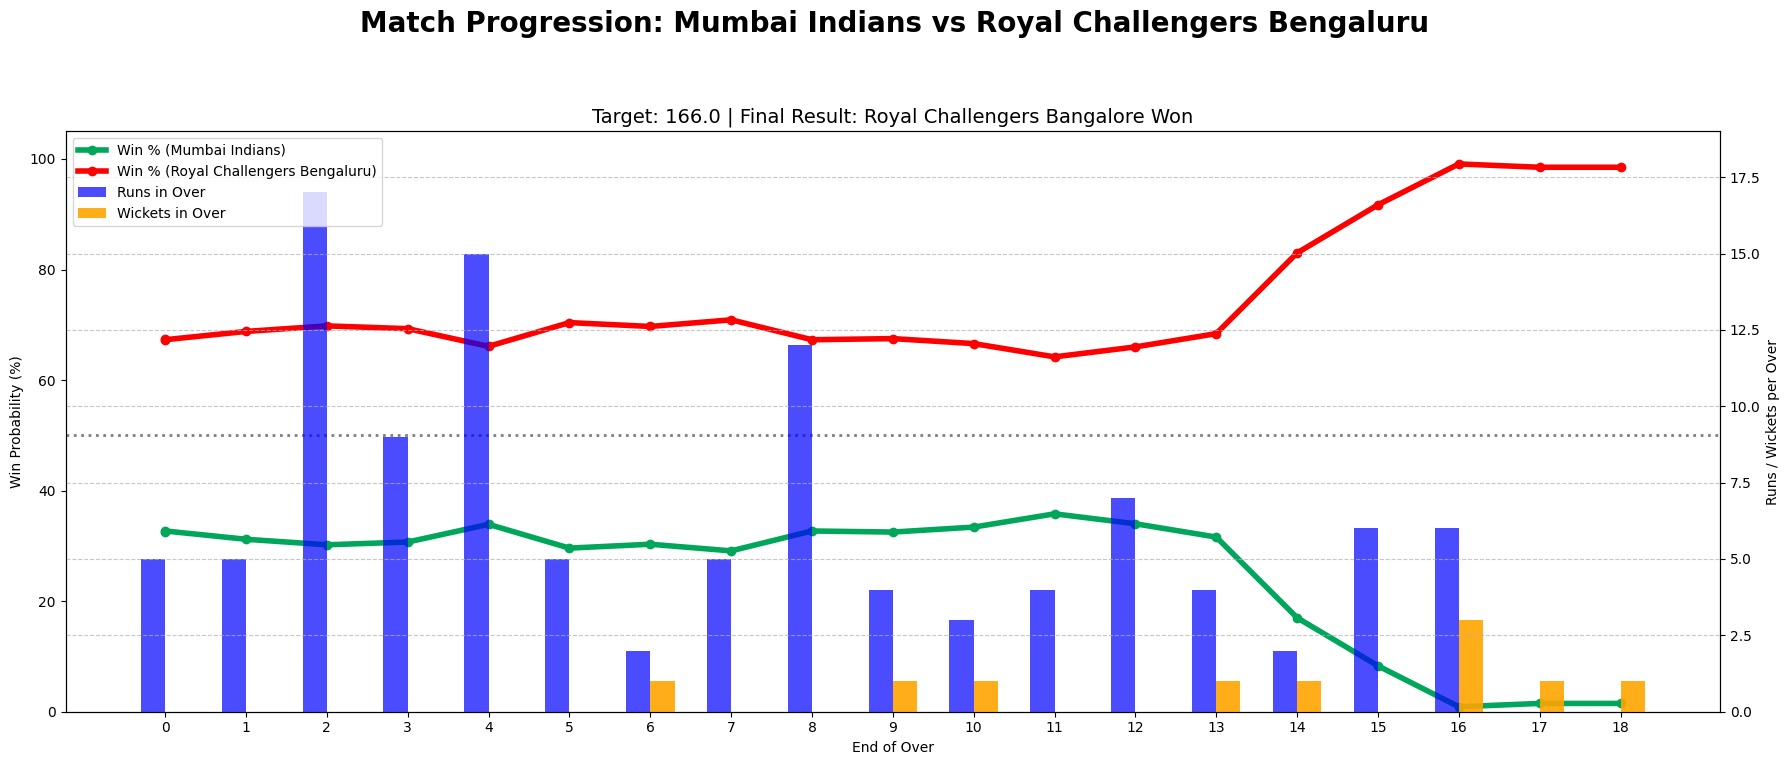


--- Script Finished ---


In [38]:
# --- 11. Test the Match Progression Function and Plot (Updated Title) ---
print("\n--- Testing Match Progression Function ---")

test_match_id = 1254108 #1473511#729287 #1426287 # Example: MI vs GT 2024/03/24

if test_match_id not in match_df['match_id'].unique():
    print(f"Warning: Test Match ID {test_match_id} not found. Trying the first available match ID.")
    available_matches = match_df['match_id'].unique()
    if len(available_matches) > 0:
        test_match_id = available_matches[0]
    else:
        print("Error: No match IDs available. Cannot test progression.")
        test_match_id = None

if test_match_id:
    # The function now returns a details dictionary
    progression_df, match_info = match_progression_rf(match_df, test_match_id, rf_model, preprocessor)

    if progression_df is not None and not progression_df.empty:
        print("\n--- Plotting Match Progression ---")
        fig, ax1 = plt.subplots(figsize=(18, 8))

        # --- Probability Lines (Primary Y-Axis) ---
        ax1.plot(progression_df['end_of_over'], progression_df['win'], color='#00a65a', linewidth=4, marker='o', label=f"Win % ({match_info['batting_team']})")
        ax1.plot(progression_df['end_of_over'], progression_df['lose'], color='red', linewidth=4, marker='o', label=f"Win % ({match_info['bowling_team']})")
        ax1.axhline(y=50, color='grey', linestyle=':', linewidth=2)
        ax1.set_xlabel("End of Over")
        ax1.set_ylabel("Win Probability (%)")
        ax1.set_ylim(0, 105)

        # --- Runs and Wickets (Secondary Y-Axis) using Grouped Bars ---
        ax2 = ax1.twinx()
        bar_width = 0.3
        ax2.bar(progression_df['end_of_over'] - bar_width/2, progression_df['runs_after_over'], 
                color='blue', alpha=0.7, width=bar_width, label="Runs in Over")
        ax2.bar(progression_df['end_of_over'] + bar_width/2, progression_df['wickets_in_over'], 
                color='orange', alpha=0.9, width=bar_width, label="Wickets in Over")
        ax2.set_ylabel("Runs / Wickets per Over")
        ax2.set_ylim(0, max(10, progression_df['runs_after_over'].max() + 2, progression_df['wickets_in_over'].max() * 5))

        # --- Create a detailed title and subtitle ---
        title_text = f"Match Progression: {match_info['batting_team']} vs {match_info['bowling_team']}"
        subtitle_text = f"Target: {match_info['target']} | Final Result: {match_info['winner']} Won"
        
        fig.suptitle(title_text, fontsize=20, fontweight='bold')
        ax1.set_title(subtitle_text, fontsize=14)

        # --- Final Touches ---
        max_over = int(progression_df['end_of_over'].max())
        ax1.set_xticks(range(0, max_over + 1))
        
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper left')

        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        fig.tight_layout(rect=[0, 0.03, 1, 0.93]) # Adjust layout to make space for suptitle
        plt.show()
    else:
        print(f"Could not generate progression plot for Match ID {test_match_id}.")

print("\n--- Script Finished ---")

In [39]:
import numpy as np
import pandas as pd

# Assuming 'ipl_df' is your DataFrame loaded with the IPL data
# For example: ipl_df = pd.read_csv('your_ipl_data.csv')

# Get the unique match IDs as before
unique_ids = ipl_df['match_id'].unique()

# --- THE FIX ---
# Set NumPy's print options to display the full array without truncation
np.set_printoptions(threshold=np.inf)

# Now, print the array again. It will show all the IDs.
print("--- Full List of Unique Match IDs ---")
print(unique_ids)

# You can reset it to the default later if you want
# np.set_printoptions(threshold=1000) # The default threshold is 1000

--- Full List of Unique Match IDs ---
[ 335982  335983  335984  335985  335986  335987  335988  335989  335990
  335991  335992  335993  335994  335995  335996  335997  335998  335999
  336000  336001  336003  336034  336004  336005  336006  336007  336008
  336009  336010  336011  336013  336014  336015  336016  336017  336018
  336020  336021  336022  336023  336024  336025  336026  336027  336028
  336029  336031  336032  336033  336002  336035  336036  336037  336012
  336019  336038  336039  336040  392181  392182  392183  392184  392185
  392186  392188  392189  392190  392191  392192  392194  392195  392196
  392197  392198  392199  392200  392201  392202  392203  392204  392205
  392206  392207  392208  392209  392210  392211  392212  392213  392214
  392215  392216  392217  392218  392219  392220  392221  392222  392223
  392224  392225  392226  392227  392228  392229  392230  392231  392232
  392233  392234  392235  392236  392237  392238  392239  419106  419107
  419108  419

In [40]:
import joblib
from tensorflow.keras.models import save_model

# --- 12. Export Models and Preprocessor for Web Deployment (Corrected) ---
print("\\n--- Exporting Models and Preprocessor for Web Deployment ---")

# Export the Random Forest model (joblib is correct for this)
joblib.dump(rf_model, 'rf_model.joblib')
print("Random Forest model saved as rf_model.joblib")

# Export the ANN model using the standard Keras format (.h5)
save_model(model, 'ann_model.h5')
print("ANN model saved as ann_model.h5")

# Export the ColumnTransformer (preprocessor)
joblib.dump(preprocessor, 'preprocessor.joblib')
print("Preprocessor saved as preprocessor.joblib")

# Export the Scaler used for the ANN
joblib.dump(scaler, 'scaler.joblib')
print("Scaler saved as scaler.joblib")

print("\\n--- All artifacts exported successfully! ---")


\n--- Exporting Models and Preprocessor for Web Deployment ---
Random Forest model saved as rf_model.joblib
ANN model saved as ann_model.h5
Preprocessor saved as preprocessor.joblib
Scaler saved as scaler.joblib
\n--- All artifacts exported successfully! ---
